/Users/asanmydeen/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Type of data: <class 'list'>
Number of samples: 5020
X shape: (5020, 42)
y shape: (5020,)
Train size: 4016 Test size: 1004


Epoch 1/50
126/126 [==============================] - 5s 21ms/step - loss: 1.5301 - accuracy: 0.4604 - val_loss: 1.8120 - val_accuracy: 0.5498
Epoch 2/50
126/126 [==============================] - 2s 15ms/step - loss: 0.8635 - accuracy: 0.6990 - val_loss: 1.3367 - val_accuracy: 0.7859
Epoch 3/50
126/126 [==============================] - 2s 13ms/step - loss: 0.7417 - accuracy: 0.7343 - val_loss: 0.8885 - val_accuracy: 0.8137
Epoch 4/50
126/126 [==============================] - 1s 12ms/step - loss: 0.6462 - accuracy: 0.7602 - val_loss: 0.5685 - val_accuracy: 0.8307
Epoch 5/50
126/126 [==============================] - 1s 11ms/step - loss: 0.6207 - accuracy: 0.7672 - val_loss: 0.4450 - val_accuracy: 0.8446
Epoch 6/50
126/126 [==============================] - 1s 12ms/step - loss: 0.5704 - accuracy: 0.7866 - val_loss: 0.3995 - val_accuracy: 0.8546
Epoch 7/50
126/126 [==============================] - 2s 12ms/step - loss: 0.5358 - accuracy: 0.8003 - val_loss: 0.3751 - val_accuracy: 0.8665

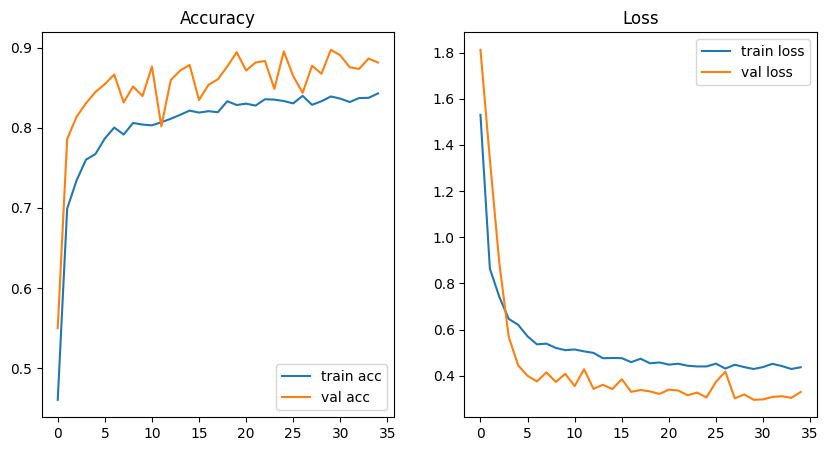

32/32 [==============================] - 0s 6ms/step - loss: 0.2958 - accuracy: 0.8974

✅ Test Accuracy: 89.74%
32/32 [==============================] - 0s 4ms/step

📋 Classification Report:
              precision    recall  f1-score   support

        okay       0.95      0.97      0.96       101
       peace       0.97      1.00      0.99       101
   thumbs up       0.88      0.96      0.92       100
 thumbs down       0.98      0.99      0.99       100
     call me       0.77      0.81      0.79       100
        stop       0.73      0.77      0.75       100
        rock       0.94      0.92      0.93       101
   live long       0.79      0.74      0.76       100
        fist       0.99      0.81      0.89       100
       smile       0.99      1.00      1.00       101

    accuracy                           0.90      1004
   macro avg       0.90      0.90      0.90      1004
weighted avg       0.90      0.90      0.90      1004



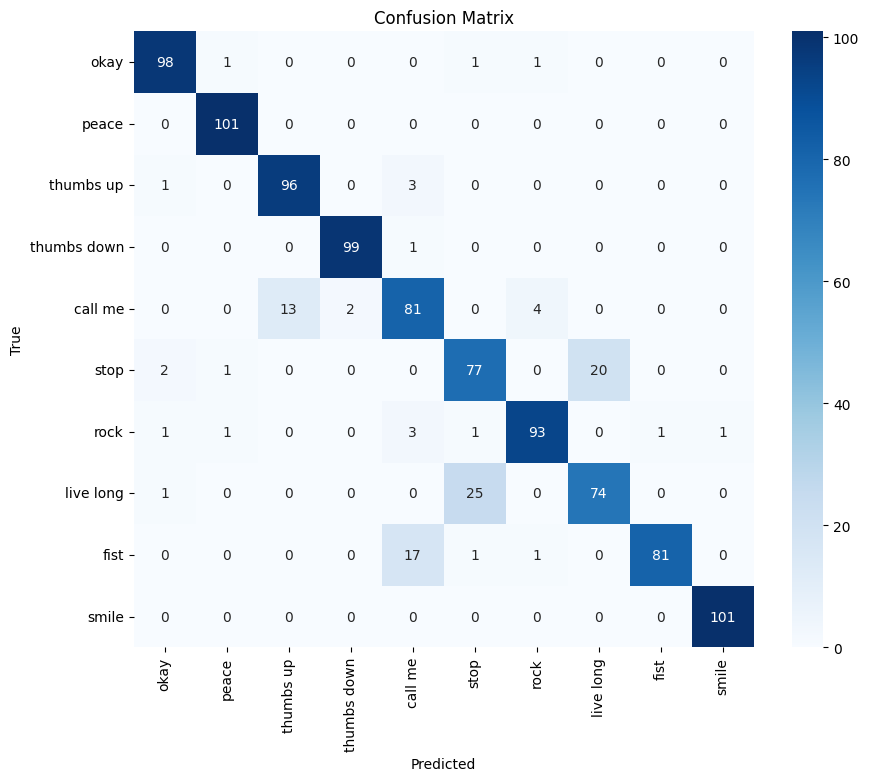


💾 Model saved as '../mp_hand_gesture_optimized.keras'


In [1]:
# -----------------------
# 📦 Import libraries
# -----------------------
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------
# 📂 Load Data
# -----------------------
with open('../data.pickle', 'rb') as f:
    data = pickle.load(f)

print("Type of data:", type(data))
print("Number of samples:", len(data))

# If your data is a list of [label, landmarks]
X = []
y = []
for item in data:
    label = item[0]
    landmarks = np.array(item[1]).flatten()  # flatten 21 (x,y) → 42
    X.append(landmarks)
    y.append(label)

X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)
print("y shape:", y.shape)

# -----------------------
# 🧠 Normalize & Split
# -----------------------
X = X / np.max(X)  # normalize coordinate values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

gestures = ['okay', 'peace', 'thumbs up', 'thumbs down', 'call me', 'stop', 'rock', 'live long', 'fist', 'smile']

print("Train size:", len(X_train), "Test size:", len(X_test))

# -----------------------
# ⚙️ Model Definition
# -----------------------
model = Sequential([
    Dense(128, activation='relu', input_shape=(42,)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(10, activation='softmax')
])

optimizer = Adam(learning_rate=0.0008)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# -----------------------
# ⏱️ Early Stopping
# -----------------------
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# -----------------------
# 🧩 Train Model
# -----------------------
history = model.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    batch_size=32,
    verbose=1
)

# -----------------------
# 📊 Plot Learning Curves
# -----------------------
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()
plt.show()

# -----------------------
# ✅ Evaluate Model
# -----------------------
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\n✅ Test Accuracy: {test_acc*100:.2f}%")

y_pred = np.argmax(model.predict(X_test), axis=-1)

print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=gestures))

# -----------------------
# 🔍 Confusion Matrix
# -----------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=gestures, yticklabels=gestures)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# -----------------------
# 💾 Save Model
# -----------------------
model.save('../mp_hand_gesture_optimized.keras')
print("\n💾 Model saved as '../mp_hand_gesture_optimized.keras'")
